In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import helper

from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import datasets, transforms

import fc_model

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

train_data = datasets.FashionMNIST('data', download=True, train=True, transform=transform)
test_data = datasets.FashionMNIST('data', download=True, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

def validation(model, testloader, criterion):
    accuracy = 0
    test_loss = 0
    for images, labels in testloader:

        images = images.resize_(images.size()[0], 784)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ## Calculating the accuracy 
        # Model's output is log-softmax, take exponential to get the probabilities
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label
        equality = (labels.data == ps.max(1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    return test_loss, accuracy


def train(model, trainloader, testloader, criterion, optimizer, epochs=2, print_every=40):
    
    steps = 0
    running_loss = 0
    for e in range(epochs):
        # Model in training mode, dropout is on
        model.train()
        for images, labels in trainloader:
            steps += 1
            
            # Flatten images into a 784 long vector
            images.resize_(images.size()[0], 784)
            
            optimizer.zero_grad()
            
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            if steps % print_every == 0:
                # Model in inference mode, dropout is off
                model.eval()
                
                # Turn off gradients for validation, will speed up inference
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion)
                
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
                
                running_loss = 0
                
                # Make sure dropout and grads are on for training
                model.train()


model = fc_model.Network(784, 10, [256, 128, 64])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [2]:
train(model, train_loader, test_loader, criterion, optimizer)

/Users/fainle/ud/data_scientist/0305/fc_model.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch: 1/2..  Training Loss: 1.982..  Test Loss: 1.286..  Test Accuracy: 0.551
Epoch: 1/2..  Training Loss: 1.346..  Test Loss: 0.884..  Test Accuracy: 0.682
Epoch: 1/2..  Training Loss: 1.102..  Test Loss: 0.734..  Test Accuracy: 0.732
Epoch: 1/2..  Training Loss: 0.941..  Test Loss: 0.705..  Test Accuracy: 0.726
Epoch: 1/2..  Training Loss: 0.879..  Test Loss: 0.651..  Test Accuracy: 0.735
Epoch: 1/2..  Training Loss: 0.861..  Test Loss: 0.624..  Test Accuracy: 0.763
Epoch: 1/2..  Training Loss: 0.777..  Test Loss: 0.602..  Test Accuracy: 0.766
Epoch: 1/2..  Training Loss: 0.780..  Test Loss: 0.598..  Test Accuracy: 0.772
Epoch: 1/2..  Training Loss: 0.744..  Test Loss: 0.566..  Test Accuracy: 0.783
Epoch: 1/2..  Training Loss: 0.751..  Test Loss: 0.574..  Test Accuracy: 0.778
Epoch: 1/2..  Training Loss: 0.739..  Test Loss: 0.558..  Test Accuracy: 0.794
Epoch: 1/2..  Training Loss: 0.692..  Test Loss: 0.555..  Test Accuracy: 0.786
Epoch: 1/2..  Training Loss: 0.708..  Test Loss: 0.5

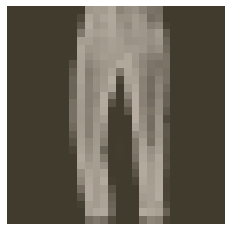

In [3]:
image, label = next(iter(train_loader))
helper.imshow(image[0])

In [5]:
print(model.state_dict().keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


In [6]:
torch.save(model.state_dict(), 'model.pth')

In [7]:
state_dict = torch.load('model.pth')

In [9]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [10]:
model

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (output): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [12]:
checkpoint = {'input_size': 784, 
              'output_size': 10, 
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

In [13]:
def load_checkpint(filepath):
    checkpoint = torch.load(filepath)
    
    model = fc_model.Network(
        checkpoint['input_size'],
        checkpoint['output_size'],
        checkpoint['hidden_layers'],
    )
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [14]:
model = load_checkpint('checkpoint.pth')

In [15]:
model

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (output): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)